In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import gumbel_r, norm, expon
import matplotlib.pyplot as plt
import pymc3 as pm

# Simulation Study 1
a
In this simulation study, we will examine two teams with some underlying latent strength being drawn from both an Extreme Value Distribution (Gumbel) and Normal Distribution. We will then analyze the results using a Bradley-Terry model and Thurstone-Mollster model, respectively.

The specifications of the parameters for each of the two contestants is shown below:



AttributeError: 'numpy.ndarray' object has no attribute 'legend'

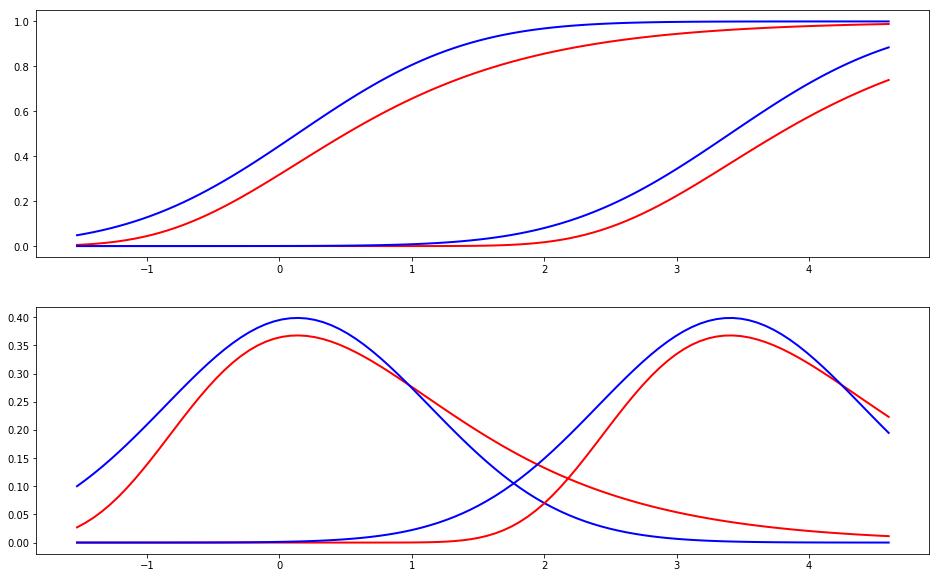

In [3]:
# simulate six contestants from each distribution
fig, ax = plt.subplots(2, 1, figsize=(16,10))

contestant_scale_parameter = expon.rvs(size=2, random_state=123456)

x = np.linspace(gumbel_r.ppf(0.01), gumbel_r.ppf(0.99), 100)
for index in range(len(contestant_scale_parameter)):
    rv = gumbel_r(contestant_scale_parameter[index])
    ax[0].plot(x, rv.cdf(x), 'k-', lw=2, color='red')
    ax[1].plot(x, rv.pdf(x), 'k-', lw=2, color='red')
    rv = norm(contestant_scale_parameter[index])
    ax[0].plot(x, rv.cdf(x), 'k', lw=2, color='blue')
    ax[1].plot(x, rv.pdf(x), 'k', lw=2, color='blue')
    
ax.legend(loc='best', frameon=False)

In [4]:
# simulate matches
matches = np.zeros((10000,2))
match_results = np.zeros((len(matches),1))
for index in range(len(matches)):
    matches[index] = np.random.choice(len(contestant_scale_parameter), 2, replace=False)
    match_results[index] = gumbel_r.rvs(contestant_scale_parameter[int(matches[index,0])], size=1) > gumbel_r.rvs(gumbel_r.rvs(contestant_scale_parameter[int(matches[index,1])], size=1))

[[0.0686]
 [0.9314]]
--
[[0.13578517]
 [3.40273372]]
[[   0.  686.]
 [9314.    0.]]


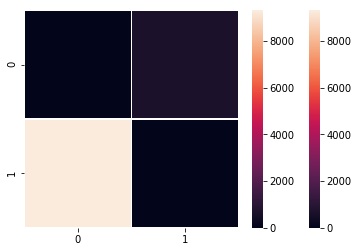

In [5]:
def generate_win_rate_matrix(matches, match_results):
    number_of_contestants = np.max(matches) + 1
    win_rate_matrix = np.zeros((int(number_of_contestants), int(number_of_contestants)))
    for contestant_index in range(int(number_of_contestants)):
        for match_index in range(len(matches)):
            if contestant_index == matches[match_index, 0]:
                if match_results[match_index] == 1:
                    win_rate_matrix[contestant_index, int(matches[match_index, 1])] += 1
            elif contestant_index == matches[match_index, 1]:
                if match_results[match_index] == 0:
                    win_rate_matrix[contestant_index, int(matches[match_index, 0])] += 1
                    
    ax = sns.heatmap(win_rate_matrix, linewidth=0.5)
                
    return win_rate_matrix

def generate_win_rate_by_contestant(matches, match_results):
    number_of_contestants = np.max(matches) + 1
    total_wins = np.zeros((int(number_of_contestants),1))
    total_matches = np.zeros((int(number_of_contestants),1))
    for contestant_index in range(int(number_of_contestants)):
        for match_index in range(len(matches)):
            if contestant_index == matches[match_index, 0]:
                total_matches[contestant_index] += 1
                if match_results[match_index] == 1:
                    total_wins[contestant_index] += 1
            elif contestant_index == matches[match_index, 1]:
                total_matches[contestant_index] += 1
                if match_results[match_index] == 0:
                    total_wins[contestant_index] += 1
                
    return total_wins/total_matches

print(generate_win_rate_by_contestant(matches, match_results))
print('--')
print(contestant_scale_parameter.reshape((2,1)))
print(generate_win_rate_matrix(matches, match_results))
win_rate_matrix = generate_win_rate_matrix(matches, match_results)

In [6]:
(contestant_scale_parameter - np.mean(contestant_scale_parameter))/np.std(contestant_scale_parameter)

array([-1.,  1.])

In [328]:
import theano
import theano.tensor as T
import numpy as np

vector1 = T.vector('vector1')
vector2 = T.vector('vector2')

output, updates = theano.scan(fn=lambda a, b : a * b,
                              sequences=[vector1, vector2])

output, updates = theano.scan(fn=lambda )
f = theano.function(inputs=[vector1, vector2],
                    outputs=output,
                    updates=updates)

vector1_value = np.arange(0, 5).astype(theano.config.floatX) # [0,1,2,3,4]
vector2_value = np.arange(1, 6).astype(theano.config.floatX) # [1,2,3,4,5]
print(f(vector1_value, vector2_value)) 


[ 0.  2.  6. 12. 20.]


In [7]:
win_rate_matrix

array([[   0.,  686.],
       [9314.,    0.]])

In [10]:
import theano.tensor as tt

with pm.Model() as model:
    # strength prior
    #strengths = pm.Gumbel('strengths', mu=0, beta=5, shape=2)
    strengths = pm.Normal('strengths', mu=0, sd=25, shape=2)
    
    # custom loglikelihood function
    def logp(win_rate_matrix):
        return win_rate_matrix[0,1]*(strengths[0] - tt.log(tt.exp(strengths[0]) + tt.exp(strengths[1]))) + win_rate_matrix[1,0]*(strengths[1] - tt.log(tt.exp(strengths[0]) + tt.exp(strengths[1])))
    
    logp = pm.DensityDist('like', logp, observed=win_rate_matrix)
    trace = pm.sample(10000, tune=10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [strengths]
Sampling 4 chains: 100%|██████████| 80000/80000 [10:41<00:00, 124.79draws/s]
The acceptance probability does not match the target. It is 0.7137380911443123, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.9013116874322937, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5493936437503296, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tre

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa9f3e57cf8>,
      dtype=object)

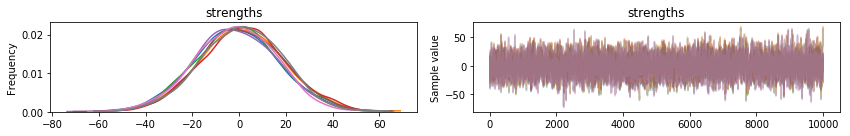

In [12]:
pm.traceplot(trace)

In [1]:
x = np.mean(trace['strengths'], axis=0)
x

NameError: name 'np' is not defined

In [359]:
np.exp(x[1])/(np.exp(x[0]) + np.exp(x[1])) # matches win-rate from above

0.9273461648069445

# Extending to $n$ > 2 Teams

In [ ]:
# TODO: Write compact form of likelihood function for n > 2 teams
# TODO: Perform check on multiple teams, examine convergence issues (if any)
# TODO: Add "Home Field Advantage" simulation